# Scripts related to venv
### Open a terminal
- .venv\Scripts\activate
- py -m pip install --upgrade pip
- py -m pip install requests
- py -m pip freeze > requirements.txt
- py -m pip install -r requirements.txt

# AWS Article
- https://induraj2020.medium.com/how-to-access-the-s3-bucket-using-python-ecdbe5ebc45f

# Music Genre Classification
In this notebook I tried to learn the basic concepts of neural networks and use it to classify the music files in dataset. Majorly this notebook can be divided into 3 parts:

   1) Using ANN 

   2) Tackling overfitting with ANN

   3) Using CNN


Also to read the dataset I have used librosa library which only read files <1Mb and one file is greater than the size giving error due to which I have ignored it. The dataset contains the following genres, the keys being the prediction targets
    
    0: "disco",
    1: "metal",
    2: "reggae",
    3: "blues",
    4: "rock",
    5: "classical",
    6: "jazz",
    7: "hiphop",
    8: "country",
    9: "pop"


In [42]:
import os
from PIL import Image
import boto3
import math
import json
import matplotlib.pyplot as plt
import io
import numpy as np
import warnings
import requests
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Model # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import f1_score, accuracy_score, auc, roc_curve
warnings.filterwarnings("ignore")

In [2]:
def load_image(bucket_name, image_key, target_size=(128, 128)):
    s3 = boto3.client('s3')
    image_data = s3.get_object(Bucket=bucket_name, Key=image_key)['Body'].read()

    image = Image.open(io.BytesIO(image_data)).convert('RGB')

    image = image.resize(target_size)

    return np.array(image) / 255.0

In [3]:
def load_images(bucket_name, dataset_path, target_size=(128, 128)):
    images = []
    labels = []
    label_mapping = {}
    s3 = boto3.client('s3')
    paginator = s3.get_paginator('list_objects_v2')

    for i, page in enumerate(paginator.paginate(Bucket=bucket_name, Prefix=dataset_path)):
        if 'Contents' not in page:
            continue
        
        for obj in page['Contents']:
            image_key = obj['Key']
            if image_key.endswith(".png"):
                genre_label = image_key.split('/')[-2]

                if genre_label not in label_mapping:
                    label_mapping[genre_label] = len(label_mapping)

                image_array = load_image(bucket_name, image_key, target_size)

                images.append(image_array)
                labels.append(label_mapping[genre_label])

    return np.array(images), np.array(labels)

In [4]:
images, labels = load_images(bucket_name='flights12345', dataset_path=r"Data/images_original")

## Create training/validation/testing


In [5]:
np.random.seed(123)
train_size = int(0.7 * 999)
test_size = int(0.15 * 999)
validation_size = int(0.15 * 999)

groups = np.array([0] * train_size + [1] * test_size + [2] * validation_size)
np.random.shuffle(groups)

In [6]:
train_images, validation_images, test_images = [], [], []
train_labels, validation_labels, test_labels = np.array([]), np.array([]), np.array([])

for i, group in enumerate(groups):
    if group == 0:
        train_images.append(images[i])
        train_labels = np.append(train_labels, int(labels[i]))
    elif group == 1:
        validation_images.append(images[i])
        validation_labels = np.append(validation_labels, int(labels[i]))
    else:
        test_images.append(images[i])
        test_labels = np.append(test_labels, int(labels[i]))

In [7]:
train_images, validation_images, test_images = np.array(train_images), np.array(validation_images), np.array(test_images)
train_labels, validation_labels, test_labels = to_categorical(train_labels, num_classes=10), to_categorical(validation_labels, num_classes=10), to_categorical(test_labels, num_classes=10)

## Create IMFs


In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

def find_extrema(signal):
    maxima = []
    minima = []
    
    for i in range(1, len(signal) - 1):
        if signal[i-1] < signal[i] > signal[i+1]:
            maxima.append(i)
        elif signal[i-1] > signal[i] < signal[i+1]:
            minima.append(i)
            
    return np.array(maxima), np.array(minima)

def compute_envelope(t, signal, extrema):
    if len(extrema) > 0:
        if extrema[0] > 0:
            extrema = np.r_[0, extrema]
        if extrema[-1] < len(signal) - 1:
            extrema = np.r_[extrema, len(signal) - 1]
            
        return CubicSpline(extrema, signal[extrema])(t)
    return np.zeros_like(signal)

def IMFextraction(signal, max_iterations=10, tolerance=0.1):
    s = signal.copy()
    l = np.arange(len(signal))
    
    for _ in range(max_iterations):
        maxima, minima = find_extrema(s)
        
        if len(maxima) + len(minima) < 3:
            break
            
        upper_envelope = compute_envelope(l, s, maxima)
        lower_envelope = compute_envelope(l, s, minima)
        mean_envelope = (upper_envelope + lower_envelope) / 2
        
        s_previous = s.copy()
        s = s - mean_envelope
        
        if np.all(np.abs((s_previous - s) / (s_previous + np.finfo(float).eps)) < tolerance):
            break
            
    return s

def decompose_to_imfs(signal, extract_imf, num_imfs=3):
    imfs = []
    residual = signal.copy()
    
    for _ in range(num_imfs):
        imf = extract_imf(residual)
        imfs.append(imf)
        residual = residual - imf
        
    return np.array(imfs)

def process_images_imf(image_set, num_imfs=3, reshape_size=(128, 128, 3)):
    processed_images = []
    
    for img in image_set:
        img_reshaped = img.reshape(reshape_size)
        
        channel_imfs = []
        for channel in range(3):
            channel_data = img_reshaped[:, :, channel].flatten()
            imfs = decompose_to_imfs(channel_data, num_imfs)
            channel_imfs.append(imfs)
            
        processed_images.append(channel_imfs)
    
    return np.array(processed_images)

def visualize_images_imf(original_image, imfs, genre_mapping, label, num_imfs_to_show=3):
    plt.figure(figsize=(15, 5 * (num_imfs_to_show + 1)))
    
    genre_names = {v: k for k, v in genre_mapping.items()}
    genre = genre_names.get(label, "Unknown")
    
    plt.subplot(num_imfs_to_show + 1, 1, 1)
    plt.imshow(original_image.reshape(128, 128, 3))
    plt.title(f'Original Image - Genre: {genre}')
    plt.axis('off')
    
    for i in range(num_imfs_to_show):
        plt.subplot(num_imfs_to_show + 1, 1, i + 2)
        
        imf_image = np.zeros((128, 128, 3))
        for c in range(3):
            imf_image[:, :, c] = imfs[c][i].reshape(128, 128)
            
        plt.imshow(imf_image + 0.5)
        plt.title(f'IMF {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

genre_mapping = {
    "disco": 0,
    "metal": 1,
    "reggae": 2,
    "blues": 3,
    "rock": 4,
    "classical": 5,
    "jazz": 6,
    "hiphop": 7,
    "country": 8,
    "pop": 9
}

def process_and_visualize(train_images, train_labels, num_samples=3, num_imfs=3):
    indices = np.random.choice(len(train_images), num_samples, replace=False)
    
    for idx in indices:
        image = train_images[idx]
        label = train_labels[idx]
        
        imfs = process_images_imf(image.reshape(1, -1), num_imfs)[0]
        
        visualize_images_imf(image, imfs, genre_mapping, label, num_imfs)



## Feed into FCN for feature extraction


In [8]:
def build_fcn(input_shape=(train_images.shape[1:]), num_classes=10):
    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=input_shape))

    # Conv1: 3×3 convolution, 128 filters
    model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 4), padding="same"))

    # Conv2: 3×3 convolution, 384 filters
    model.add(layers.Conv2D(384, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(4, 4), padding="same"))

    # Conv3: 3×3 convolution, 768 filters
    model.add(layers.Conv2D(768, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), padding="same"))

    # Conv4: 3×3 convolution, 2048 filters
    model.add(layers.Conv2D(2048, (3, 3), padding="same", activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(4, 4), padding="same"))  

    # Output layer: 1×1 convolutional layer for 10 classes
    model.add(layers.Conv2D(num_classes, (1, 1), activation="sigmoid"))

    model.add(layers.GlobalAveragePooling2D())

    return model
    

In [9]:
model_fcn = build_fcn()
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_fcn.compile(optimizer=adam_opt, loss="binary_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

model_fcn.fit(train_images, train_labels, validation_data=(validation_images,validation_labels), batch_size=16, epochs=100, callbacks=[early_stopping])

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 881ms/step - accuracy: 0.0923 - loss: 0.4176 - val_accuracy: 0.0940 - val_loss: 0.3256
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 882ms/step - accuracy: 0.1080 - loss: 0.3273 - val_accuracy: 0.0872 - val_loss: 0.3227
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 869ms/step - accuracy: 0.1453 - loss: 0.3156 - val_accuracy: 0.2013 - val_loss: 0.2991
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 859ms/step - accuracy: 0.2567 - loss: 0.2928 - val_accuracy: 0.2013 - val_loss: 0.3081
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 826ms/step - accuracy: 0.2660 - loss: 0.2896 - val_accuracy: 0.3087 - val_loss: 0.2779
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 852ms/step - accuracy: 0.3030 - loss: 0.2732 - val_accuracy: 0.3758 - val_loss: 0.2702
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 912ms/step - accuracy: 0.3906 - loss: 0.2613 - val_accuracy: 0.3691 - val_loss: 0.2677
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 39s 881ms/step - accuracy: 0.4140 - loss: 0.2531 - 

## Feed into SVM

In [ ]:
penultimate_layer_model = Model(inputs=model_fcn.inputs, outputs=model_fcn.layers[-2].output)
features_train = penultimate_layer_model.predict(train_images)

flattened_features_train = features_train.reshape(features_train.shape[0], -1)

scaler_train = StandardScaler()
scaled_features_train = scaler_train.fit_transform(flattened_features_train)
param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],  
              'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose=3)
grid.fit(scaled_features_train, [np.argmax(i) for i in train_labels])

In [12]:
grid.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

## Feed into Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=1000)

rf.fit(scaled_features_train, [np.argmax(i) for i in train_labels])

RandomForestClassifier(n_estimators=1000)

## Testing SVM

In [14]:
features_test = penultimate_layer_model.predict(test_images)

flattened_features_test = features_test.reshape(features_test.shape[0], -1)

scaler_test = StandardScaler()
scaled_features_test = scaler_test.fit_transform(flattened_features_test)

test_pred = grid.predict(scaled_features_test)
accuracy_score([np.argmax(i) for i in test_labels], test_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step


0.6375838926174496

## Testing Random Forest

In [51]:
test_pred_rf = rf.predict(scaled_features_test)
accuracy_score([np.argmax(i) for i in test_labels], test_pred_rf)

0.6510067114093959

## Visualizations

In [35]:
train_accuracy = model_fcn.history.history['accuracy']
val_accuracy = model_fcn.history.history['val_accuracy']  # Training accuracy

In [55]:
val_loss = model_fcn.history.history['val_loss']

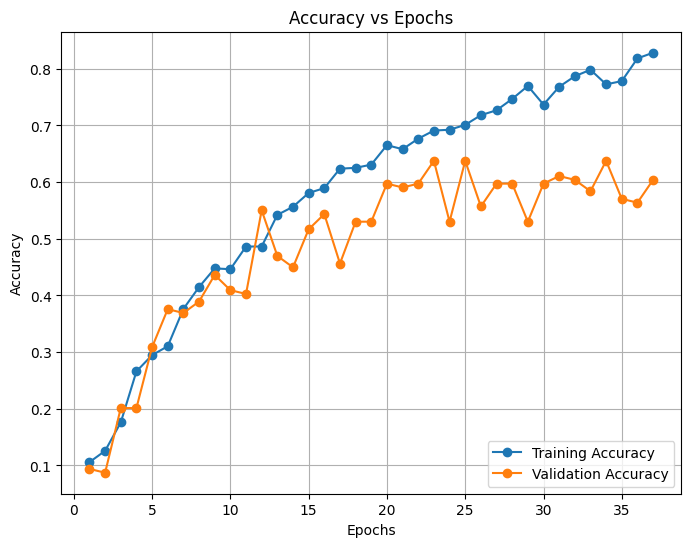

In [36]:
# Plotting accuracy vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(val_accuracy)+1), train_accuracy, label='Training Accuracy', marker='o')
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, label='Validation Accuracy', marker='o')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


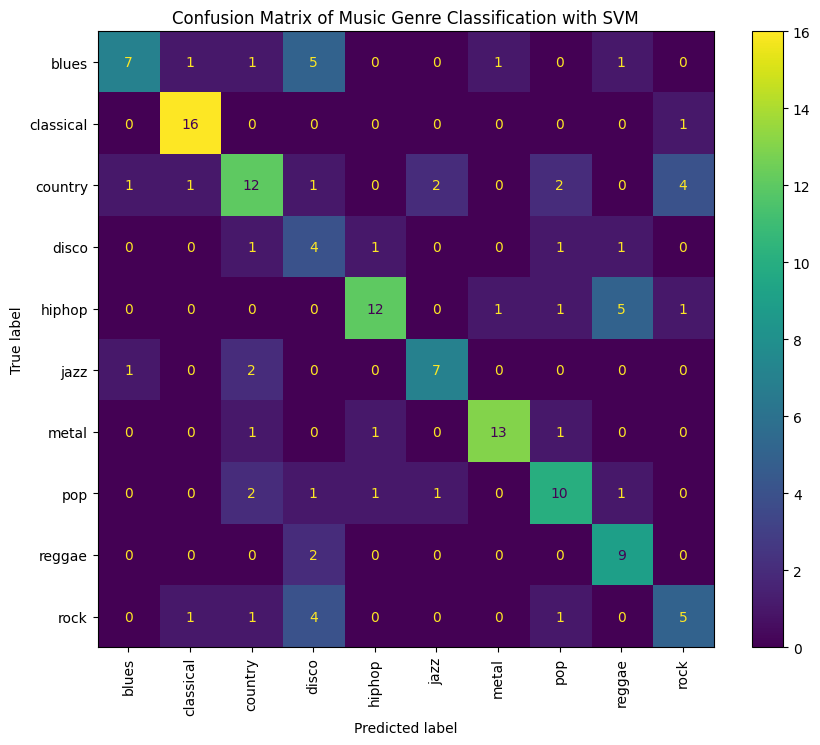

In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example setup: 10 music genres
genres = ['blues',

'classical',

'country',

'disco',

'hiphop',

'jazz',

'metal',

'pop',

'reggae',

'rock',
]

conf_matrix_svm = confusion_matrix([np.argmax(i) for i in test_labels], test_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=genres)
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical', colorbar=True)
plt.title("Confusion Matrix of Music Genre Classification with SVM")
plt.show()


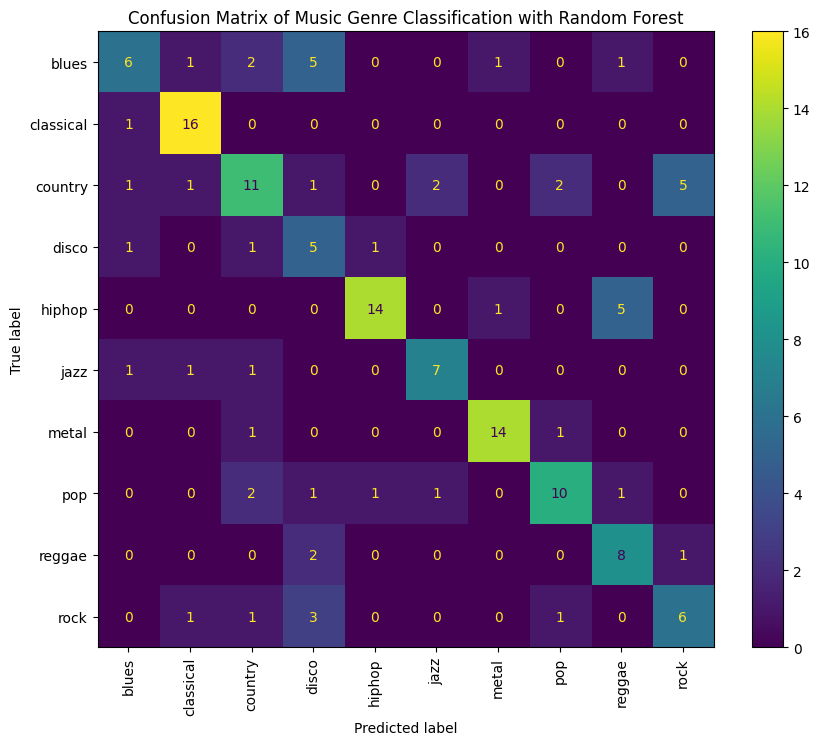

In [53]:
conf_matrix_rf = confusion_matrix([np.argmax(i) for i in test_labels], test_pred_rf)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=genres)
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical', colorbar=True)
plt.title("Confusion Matrix of Music Genre Classification with Random Forest")
plt.show()

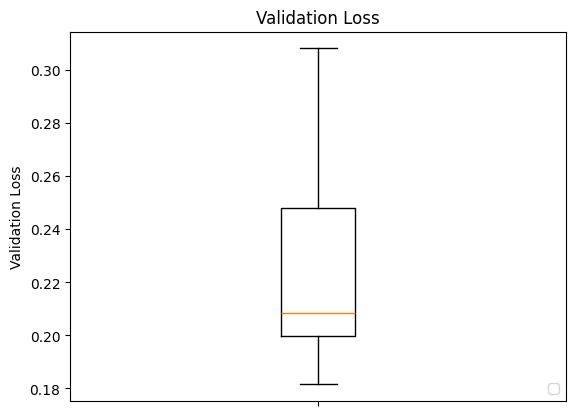

In [70]:
plt.boxplot(val_loss, showfliers=False)
plt.ylabel('Validation Loss')
plt.tick_params(axis='x', labelbottom=False) 
plt.title('Validation Loss')
plt.legend(loc='lower right')
plt.show()

<BarContainer object of 2 artists>

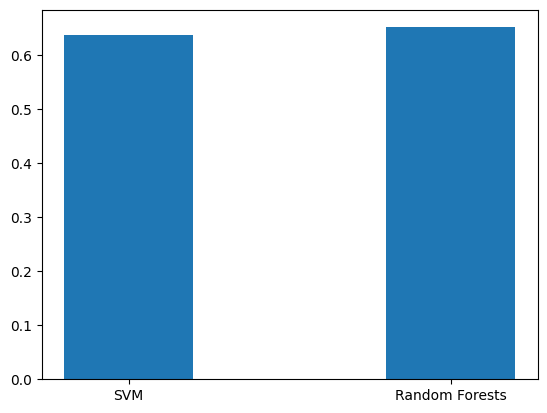

In [75]:
plt.bar(['SVM', 'Random Forests'], [accuracy_score([np.argmax(i) for i in test_labels], test_pred), accuracy_score([np.argmax(i) for i in test_labels], test_pred_rf)], width=0.4)

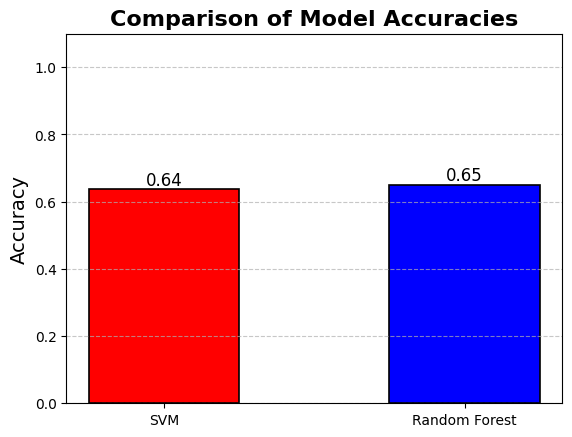

In [80]:
svm_accuracy = accuracy_score([np.argmax(i) for i in test_labels], test_pred)
rf_accuracy = accuracy_score([np.argmax(i) for i in test_labels], test_pred_rf)

# Bar plot data
methods = ['SVM', 'Random Forest']
accuracies = [svm_accuracy, rf_accuracy]
bars = plt.bar(methods, accuracies, width=0.5, color=['red', 'blue'], edgecolor='black', linewidth=1.2)

# Add value annotations
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

# Add labels, title, and grid
plt.title('Comparison of Model Accuracies', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.1)  # Ensure space above bars
plt.grid(axis='y', linestyle='--', alpha=0.7)